In [1]:
import time
import json
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy import sparse
from tqdm import tqdm, trange

from reservoirpy.compat import ESN
from reservoirpy import mat_gen
from reservoirpy.datasets import mackey_glass, to_forecasting

import cupy as cp
import cupyx as cpx
from cupyx.time import repeat

In [2]:
def nrmse(ytrue, ypred):
    rmse = np.sqrt(np.sum((ytrue - ypred)**2)) / ytrue.shape[0]
    return rmse / (ytrue.max() - ytrue.min())

In [3]:
T = 20001
T_tot = T + 501

X = []
taus = list(range(12, 37, 3))
for tau in taus:
    X.append(mackey_glass(T_tot, tau=tau))

X = np.concatenate(X, axis=1)
X = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1
X, Xtest = X[:-501], X[-501:]

In [4]:
X, y = to_forecasting(X, forecast=1)
Xtest, ytest = to_forecasting(Xtest, forecast=1)

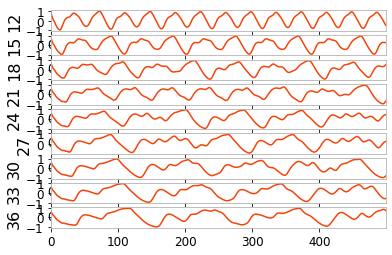

In [5]:
fig, axes = plt.subplots(len(taus), 1)
for i, tau in enumerate(taus):
    _ = axes[i].plot(X[:500, i])
    axes[i].set_ylabel(tau)

In [6]:
N = 1000

In [7]:
W32 = mat_gen.generate_internal_weights(N, sr=1.25, seed=12345).astype(np.float32)
Win32 = mat_gen.generate_input_weights(N, len(taus), input_bias=True, seed=12345).astype(np.float32)
esn32 = ESN(lr=0.3, input_bias=True, W=W32, Win=Win32, typefloat=np.float32)

In [9]:
def esn_kernel(W, Win, s, u, lr):
    xp = cp.get_array_module(s)
    x = s @ W + u @ Win.T
    x = (1 - lr) * s + lr * xp.tanh(x)
    return x

In [10]:
def esn_states_gpu(W, Win, inputs, lr, progress=True):
    states = np.zeros(shape=(len(inputs), W.shape[0]))
    s = cp.zeros(shape=(1, W.shape[0]))
    U = np.hstack([np.ones(shape=(inputs.shape[0], 1)), inputs])
    for i, u in enumerate(tqdm(U, disable=not progress)):
        u = cp.array(u).reshape(1, -1)
        s = esn_kernel(W, Win, s, u, lr)
        states[i, :] = s.get()

    return states

In [11]:
def esn_states_cpu(W, Win, inputs, lr, progress=True):
    states = np.zeros(shape=(len(inputs), W.shape[0]))
    s = np.zeros(shape=(1, W.shape[0]))
    U = np.array(inputs)
    U = np.hstack([np.ones(shape=(U.shape[0], 1)), U])
    for i, u in enumerate(tqdm(U, disable=not progress)):
        s = esn_kernel(W, Win, s, u, lr)
        states[i, :] = s

    return states

In [33]:
states_gpu = esn_states_gpu(cp.array(W32.toarray()), cp.array(Win32), X, 0.3)

In [23]:
states_cpu = esn_states_cpu(W32.toarray(), Win32, X, 0.3)

100%|██████████| 20000/20000 [00:17<00:00, 1132.68it/s]


In [14]:
perf = repeat(esn_states_gpu,
              (cp.array(W32.toarray()), cp.array(Win32), X, 0.3),
              n_repeat=20)

print(perf)

/home/nathan/.local/share/virtualenvs/reservoirpy-hiepacs-0QfWWJ0M/lib/python3.8/site-packages/cupyx/time.py:115: FutureWarning: cupyx.time.repeat is experimental. The interface can change in the future.
  _util.experimental('cupyx.time.repeat')
100%|██████████| 20000/20000 [00:06<00:00, 2980.59it/s]

esn_states_gpu      :    CPU:6734872.964 us   +/-78532.840 (min:6635970.188 / max:6983120.654) us     GPU-0:6734897.583 us   +/-78533.197 (min:6635992.676 / max:6983144.043) us


In [42]:
Ns = [100, 300, 500, 800, 1000, 2000, 5000, 10000]

In [44]:
sparse_cpu_times = defaultdict(list)
for n in Ns:
    if n not in sparse_cpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, len(taus), input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_states_cpu(W32, sparse.csr_matrix(Win32), X, 0.3, progress=False)
            sparse_cpu_times[n].append(time.time() - start)

dense_cpu_times = defaultdict(list)
for n in []: # too long, already computed
    if n not in dense_cpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, len(taus), input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_states_cpu(W32.toarray(), Win32, X, 0.3, progress=False)
            dense_cpu_times[n].append(time.time() - start)

dense_gpu_times = defaultdict(list)
for n in Ns:
    if n not in dense_gpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, len(taus), input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_states_gpu(cp.array(W32.toarray()), cp.array(Win32), X, 0.3, progress=False)
            dense_gpu_times[n].append(time.time() - start)

sparse_gpu_times = defaultdict(list)
for n in Ns:
    if n not in sparse_gpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, len(taus), input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_states_gpu(cpx.scipy.sparse.csr_matrix(W32),
                           cpx.scipy.sparse.csr_matrix(sparse.csr_matrix(Win32)), X, 0.3, progress=False)
            sparse_gpu_times[n].append(time.time() - start)

100%|██████████| 20/20 [11:09<00:00, 33.49s/it]


In [50]:
report_nobatch = Path("../resultats/cupy-nobatch")
if not report_nobatch.exists():
    report_nobatch.mkdir(parents=True)

with (report_nobatch / "cpu_sparse.json").open("w+") as fp:
    json.dump(sparse_cpu_times, fp)

with (report_nobatch / "cpu_dense.json").open("w+") as fp:
    json.dump(dense_cpu_times, fp)

with (report_nobatch / "gpu_sparse.json").open("w+") as fp:
    json.dump(sparse_gpu_times, fp)

with (report_nobatch / "gpu_dense.json").open("w+") as fp:
    json.dump(dense_gpu_times, fp)

In [299]:
report_nobatch = Path("../resultats/cupy-nobatch")
with (report_nobatch / "cpu_sparse.json").open("r") as fp:
    sparse_cpu_times = json.load(fp)

with (report_nobatch / "cpu_dense.json").open("r") as fp:
    dense_cpu_times = json.load(fp)

with (report_nobatch / "gpu_sparse.json").open("r") as fp:
    sparse_gpu_times = json.load(fp)

with (report_nobatch / "gpu_dense.json").open("r") as fp:
    dense_gpu_times = json.load(fp)

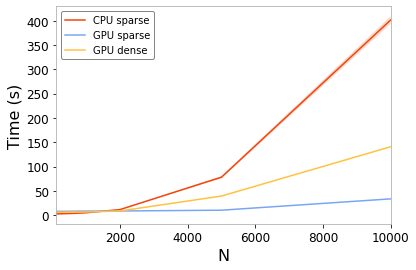

In [300]:
fig, ax = plt.subplots(1, 1)

mean_cs = np.array([np.mean(v) for v in sparse_cpu_times.values()])
std_cs = np.array([np.std(v) for v in sparse_cpu_times.values()])

mean_cd = np.array([np.mean(v) for v in dense_cpu_times.values()])
std_cd = np.array([np.std(v) for v in dense_cpu_times.values()])

mean_gs = np.array([np.mean(v) for v in sparse_gpu_times.values()])
std_gs = np.array([np.std(v) for v in sparse_gpu_times.values()])

mean_gd = np.array([np.mean(v) for v in dense_gpu_times.values()])
std_gd = np.array([np.std(v) for v in dense_gpu_times.values()])

ax.plot(Ns, mean_cs, label="CPU sparse")
ax.fill_between(Ns, mean_cs + std_cs, mean_cs - std_cs, alpha=0.2)

#ax.plot(Ns, mean_cd, label="CPU dense")
#ax.fill_between(Ns, mean_cd + std_cd, mean_cd - std_cd, alpha=0.2)

ax.plot(Ns, mean_gs, label="GPU sparse")
ax.fill_between(Ns, mean_gs + std_gs, mean_gs - std_gs, alpha=0.2)

ax.plot(Ns, mean_gd, label="GPU dense")
ax.fill_between(Ns, mean_gd + std_gd, mean_gd - std_gd, alpha=0.2)


ax.set_xlabel("N")
ax.set_ylabel("Time (s)")
_ = ax.legend()

In [53]:
def esn_batched_gpu(W, Win, inputs, lr, batch_size=100):
    states = np.zeros(shape=(len(inputs), W.shape[0]))
    s = cp.zeros(shape=(1, W.shape[0]))
    U = np.hstack([np.ones(shape=(inputs.shape[0], 1)), inputs])

    max_length = len(inputs)
    num_batches = int(np.ceil(U.shape[0] / batch_size))
    for i in range(num_batches):
        end = (i+1)*batch_size if (i+1)*batch_size < max_length else max_length
        u_batch = cp.array(U[i*batch_size:end])
        s_batch = cp.empty((u_batch.shape[0], s.shape[1]))
        for j in range(u_batch.shape[0]):
            x = s @ W + cp.dot(u_batch[j, :], Win.T)
            s = (1 - lr) * s + lr * cp.tanh(x)
            s_batch[j, :] = s.reshape(-1)
        states[i*batch_size:end] = s_batch.get()

    return states

In [73]:
states = esn_batched_gpu(cp.array(W32.toarray()), cp.array(Win32), X, 0.3, batch_size=100)

In [74]:
times = []
for i in trange(20):
    start = time.time()
    esn_batched_gpu(cp.array(W32.toarray()), cp.array(Win32), X, 0.3, batch_size=100)
    times.append(time.time() - start)

print(f"Batched (100) GPU time: {np.mean(times)} ± {np.std(times)} "
      f"(min: {np.min(times)}, max: {np.max(times)})")

100%|██████████| 20/20 [01:25<00:00,  4.27s/it]

Batched (100) GPU time: 4.271522676944732 ± 0.03828529285254913 (min: 4.230182647705078, max: 4.42503023147583)


In [26]:
batches = list(range(100, 1001, 100))
batches.insert(0, 1)

batch_gpu_times = defaultdict(lambda: defaultdict(list))
for n in Ns:
    W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
    Win32 = mat_gen.generate_input_weights(n, len(taus), input_bias=True, seed=12345).astype(np.float32)
    for batch_size in batches:
        for i in trange(20):
            start = time.time()
            esn_batched_gpu(cp.array(W32.toarray()), cp.array(Win32), X, 0.3, batch_size=batch_size)
            batch_gpu_times[n][batch_size].append(time.time() - start)

100%|██████████| 20/20 [02:09<00:00,  6.45s/it]


In [56]:
report_batch = Path("../resultats/cupy-batch")
if not report_batch.exists():
    report_batch.mkdir(parents=True)

with (report_batch / "gpu_batched.json").open("w+") as fp:
    json.dump(batch_gpu_times, fp)

In [58]:
report_batch = Path("../resultats/cupy-batch")
with (report_batch / "gpu_batched.json").open("r") as fp:
    batch_gpu_times = json.load(fp)

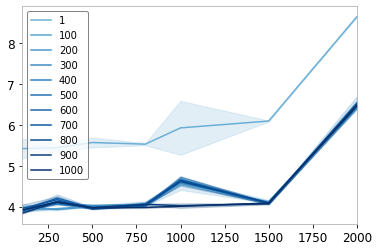

In [89]:
import matplotlib as mpl
Ns = [100, 300, 500, 800, 1000, 1500, 2000]

bgt = defaultdict(lambda: defaultdict((list)))
for n, res in batch_gpu_times.items():
    for b, values in res.items():
        bgt[b][n] = values

evenly_spaced_interval = np.linspace(0.5, 1, len(batches))
colors = [mpl.cm.Blues(x) for x in evenly_spaced_interval]

for i, (batch, res) in enumerate(bgt.items()):

    means = np.array([np.mean(v) for v in res.values()])
    stds = np.array([np.std(v) for v in res.values()])
    upper = means + stds
    lower = means - stds
    color = colors[i]
    plt.plot(Ns, means, color=color, label=batch)
    plt.fill_between(Ns, upper, lower, color=color, alpha=0.2)

plt.legend()

In [280]:
def esn_batched_gpu_with_training(W, Win, inputs, teachers, lr, batch_size=500):
    s = cp.zeros(shape=(1, W.shape[0]), dtype=np.float32)
    N = W.shape[0]
    XXT = cp.zeros(shape=(N+1, N+1), dtype=np.float32)
    YXT = cp.zeros(shape=(teachers.shape[1], N+1), dtype=np.float32)
    R = np.eye(N+1, dtype=np.float32) * 10
    U = np.hstack([np.ones(shape=(inputs.shape[0], 1)), inputs])

    max_length = len(inputs)
    num_batches = int(np.ceil(U.shape[0] / batch_size))

    for i in range(num_batches):
        end = (i+1)*batch_size if (i+1)*batch_size < max_length else max_length

        u_batch = cp.array(U[i*batch_size:end]).astype(np.float32)
        t_batch = cp.array(teachers[i*batch_size:end]).astype(np.float32)
        s_batch = cp.empty((u_batch.shape[0], s.shape[1])).astype(np.float32)

        for j in range(u_batch.shape[0]):
            x = s @ W + u_batch[j, :] @ Win.T
            s = (1 - lr) * s + lr * cp.tanh(x)
            s_batch[j, :] = s.reshape(-1)

        s_batch = cp.hstack([cp.ones((s_batch.shape[0], 1)), s_batch])

        XXT += s_batch.T @ s_batch
        YXT += t_batch.T @ s_batch

    Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")

    return Wout.T

In [281]:
def esn_batched_cpu_with_training(W, Win, inputs, teachers, lr, batch_size=500):
    N = W.shape[0]
    s = np.zeros(shape=(1, N), dtype=np.float32)
    XXT = np.zeros(shape=(N+1, N+1), dtype=np.float32)
    YXT = np.zeros(shape=(teachers.shape[1], N+1), dtype=np.float32)
    R = np.eye(N+1, dtype=np.float32) * 10
    U = np.hstack([np.ones(shape=(inputs.shape[0], 1)), inputs])

    max_length = len(inputs)
    num_batches = int(np.ceil(U.shape[0] / batch_size))

    for i in range(num_batches):
        end = (i+1)*batch_size if (i+1)*batch_size < max_length else max_length

        u_batch = np.array(U[i*batch_size:end]).astype(np.float32)
        t_batch = np.array(teachers[i*batch_size:end]).astype(np.float32)
        s_batch = np.empty((u_batch.shape[0], s.shape[1])).astype(np.float32)

        for j in range(u_batch.shape[0]):
            x = s @ W + u_batch[j, :] @ Win.T
            s = (1 - lr) * s + lr * np.tanh(x)
            s_batch[j, :] = s.reshape(-1)

        s_batch = np.hstack([np.ones((s_batch.shape[0], 1)), s_batch])

        XXT += s_batch.T @ s_batch
        YXT += t_batch.T @ s_batch

    Wout = linalg.solve(XXT + R, YXT.T, assume_a="sym")

    return Wout.T

In [282]:
T = 20001
T_tot = T + 501

X = mackey_glass(T_tot)

X = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1
X, Xtest = X[:-501], X[-501:]

In [283]:
X, y = to_forecasting(X, forecast=1)
Xtest, ytest = to_forecasting(Xtest, forecast=1)

In [284]:
N = 1000

In [285]:
W32 = mat_gen.generate_internal_weights(N, sr=1.25, seed=12345).astype(np.float32)
Win32 = mat_gen.generate_input_weights(N, 1, input_bias=True, seed=12345).astype(np.float32)

In [286]:
Wout_gpu = esn_batched_gpu_with_training(cp.array(W32.toarray()), cp.array(Win32), X, y, 0.3, batch_size=500)
Wout_cpu = esn_batched_cpu_with_training(W32, Win32, X, y, 0.3, batch_size=500)

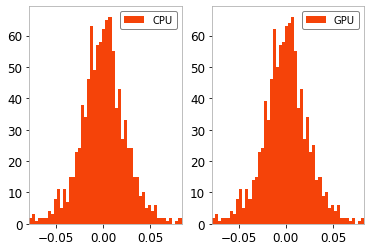

In [287]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(Wout_cpu.T, bins=50, label="CPU")
ax2.hist(Wout_gpu.T, bins=50, label="GPU")
_ = ax1.legend()
_ = ax2.legend()

In [288]:
esn32 = ESN(lr=0.3, input_bias=True, W=W32, Win=Win32, typefloat=np.float32)

In [289]:
esn32.Wout = Wout_gpu
outputs_g, _ = esn32.run([Xtest.astype(np.float32)])

esn32.Wout = Wout_cpu
outputs_c, _ = esn32.run([Xtest.astype(np.float32)])

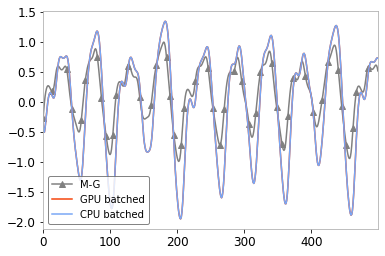

In [290]:
plt.plot(ytest[:500], label="M-G", color="gray", marker="^", markevery=0.1)
plt.plot(outputs_g[0][:500], label="GPU batched")
plt.plot(outputs_c[0][:500], label="CPU batched")
_ = plt.legend()

In [291]:
sparse_cpu_times = defaultdict(list)
dense_cpu_times = defaultdict(list)
dense_gpu_times = defaultdict(list)
sparse_gpu_times = defaultdict(list)

In [293]:
Ns = [100, 300, 500, 800, 1000, 2000, 5000, 10000]


for n in Ns:
    if n not in sparse_cpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, 1, input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_batched_cpu_with_training(W32, sparse.csr_matrix(Win32), X, y, 0.3)
            sparse_cpu_times[n].append(time.time() - start)

for n in []: #too long
    if n not in dense_cpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, 1, input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_batched_cpu_with_training(W32.toarray(), Win32, X, y, 0.3, progress=False)
            dense_cpu_times[n].append(time.time() - start)


for n in Ns:
    if n not in dense_gpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, 1, input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_batched_gpu_with_training(cp.array(W32.toarray()), cp.array(Win32), X, y, 0.3)
            dense_gpu_times[n].append(time.time() - start)


for n in Ns:
    if n not in sparse_gpu_times:
        W32 = mat_gen.generate_internal_weights(n, sr=1.25, seed=12345).astype(np.float32)
        Win32 = mat_gen.generate_input_weights(n, 1, input_bias=True, seed=12345).astype(np.float32)
        for i in trange(20):
            start = time.time()
            esn_batched_gpu_with_training(cpx.scipy.sparse.csr_matrix(W32),
                           cpx.scipy.sparse.csr_matrix(sparse.csr_matrix(Win32)), X, y, 0.3)
            sparse_gpu_times[n].append(time.time() - start)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-281-7ea10f43059a>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.89601e-08): result may not be accurate.
  Wout = linalg.solve(XXT + R, YXT.T, assume_a="sym")
  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-281-7ea10f43059a>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.14238e-08): result may not be accurate.
  Wout = linalg.solve(XXT + R, YXT.T, assume_a="sym")
  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.84686e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.14236e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix

 50%|█████     | 10/20 [06:14<06:12, 37.20s/it]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.15385e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
 55%|█████▌    | 11/20 [06:51<05:34, 37.14s/it]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.15396e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
 60%|██████    | 12/20 [07:28<04:56, 37.05s/it]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.15363e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
 65%|██████▌   | 13/20 [08:05<04:18, 36.99s/it]<ipython-input-280-b10927689026>:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.15367e-08): result may not be accurate.
  Wout = linalg.solve(XXT.get() + R, YXT.T.get(), assume_a="sym")
 75%|███████▌  | 15/20 [09:18<03:04, 36.94s/it]<ipyt

In [296]:
report_trainbatch = Path("../resultats/cupy-numpy-train-batch")
if not report_trainbatch.exists():
    report_trainbatch.mkdir(parents=True)

with (report_trainbatch / "cpu_sparse.json").open("w+") as fp:
    json.dump(sparse_cpu_times, fp)

with (report_trainbatch / "cpu_dense.json").open("w+") as fp:
    json.dump(dense_cpu_times, fp)

with (report_trainbatch / "gpu_sparse.json").open("w+") as fp:
    json.dump(sparse_gpu_times, fp)

with (report_trainbatch / "gpu_dense.json").open("w+") as fp:
    json.dump(dense_gpu_times, fp)

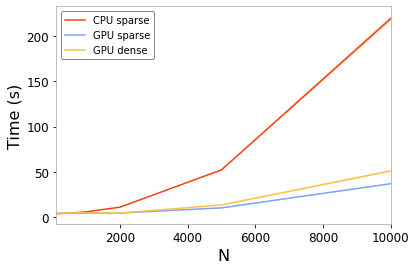

In [298]:
fig, ax = plt.subplots(1, 1)

mean_cs = np.array([np.mean(v) for v in sparse_cpu_times.values()])
std_cs = np.array([np.std(v) for v in sparse_cpu_times.values()])

mean_cd = np.array([np.mean(v) for v in dense_cpu_times.values()])
std_cd = np.array([np.std(v) for v in dense_cpu_times.values()])

mean_gs = np.array([np.mean(v) for v in sparse_gpu_times.values()])
std_gs = np.array([np.std(v) for v in sparse_gpu_times.values()])

mean_gd = np.array([np.mean(v) for v in dense_gpu_times.values()])
std_gd = np.array([np.std(v) for v in dense_gpu_times.values()])

ax.plot(Ns, mean_cs, label="CPU sparse")
ax.fill_between(Ns, mean_cs + std_cs, mean_cs - std_cs, alpha=0.2)

#ax.plot(Ns, mean_cd, label="CPU dense")
#ax.fill_between(Ns, mean_cd + std_cd, mean_cd - std_cd, alpha=0.2)

ax.plot(Ns, mean_gs, label="GPU sparse")
ax.fill_between(Ns, mean_gs + std_gs, mean_gs - std_gs, alpha=0.2)

ax.plot(Ns, mean_gd, label="GPU dense")
ax.fill_between(Ns, mean_gd + std_gd, mean_gd - std_gd, alpha=0.2)

ax.set_xlabel("N")
ax.set_ylabel("Time (s)")
_ = ax.legend()